-  IMPORTER LES PACKAGES NECESSAIRES :

In [228]:
# conda install -c conda-forge patsy

In [229]:
import numpy as np 
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from patsy import bs, dmatrix
from sklearn.inspection import permutation_importance
from scipy.stats import norm, skew
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## Visualisation des données 

* lecture des données :

In [230]:
data = pd.read_csv('data.csv')

In [233]:
data.head()

,Electricite,Temperature,Usure,Pression,Humidite,Echappement,Congestion reseau
0,411.78,8.34,81.94,1010.84,90.01,480.48,0.66
1,590.75,23.64,88.10,1011.40,74.20,445.75,0.19
2,574.69,29.74,83.94,1007.15,41.91,438.76,0.52
3,501.87,19.07,93.95,1007.22,76.79,453.09,0.61
4,410.67,11.80,77.10,1017.13,97.20,464.43,0.66


In [232]:
data.shape

(9568, 7)

    - le problème qu'on essaye de tackler est la prédiction de l'énergie produite (variable quantitative) en fonction de plusiuers variables explicatives comme la température, la pression,... 
        - il s'agit donc d'un problème de régression. 
        - On commence tout d'abord par la visualisation des données.

* une première visulaisation d'une description des données: 
    - pas de valeur manquante 
    - information sur quelques quantiles de distribution pour chaque variable/ colonne dans notre jeu de donées

In [108]:
data.describe()

,Electricite,Temperature,Usure,Pression,Humidite,Echappement,Congestion reseau
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,548.489045,19.651231,75.176034,1013.259078,73.308978,454.365009,0.403686
std,128.349688,7.452473,14.322680,5.938784,14.600269,17.066995,0.229462
min,256.140000,1.810000,50.000000,992.890000,25.560000,420.260000,0.010000
25%,421.570000,13.510000,62.880000,1009.100000,63.327500,439.750000,0.200000
50%,526.010000,20.345000,75.580000,1012.940000,74.975000,451.550000,0.400000
75%,672.050000,25.720000,87.482500,1017.260000,84.830000,468.430000,0.600000
max,823.760000,37.110000,100.000000,1033.300000,100.160000,495.760000,0.800000


-  visulisation d'un scatter plot par pair de varibales ainsi que leurs histogrammes , on peut remarquer : 
    - la varibale température exhibe une correlation significative positive avec l'Electricité. 
    - la varible Echappement a une corrélation significative négative avec l'Electricité
    - on ne peut pas trop se prononcer sur l'effet  de Pression et humidité.
         - leur  corrélation avec la variable à prédire est faible, néanmoins ils sont corrélés avec d'autres varibales qui l'explique par exemple: pression/temperature.
    - les variables usure et congestion réseau sont à la fois presque pas du tout corréles avec la varibale réponse et aussi avec les autres varibales.
         - on peut dire que à priori ils n'ont aucun apport à l'explication de la variable réponse.
- on peut remarquer également en visulisant les histogrammes que la varibale à prédire a une distribution bimodale, ceci peurt être expliqué par le fait que cette varibale est fortement impacté par les deux varibales Température et Echappement qui ont également approximativemet des distributions bimodales. 

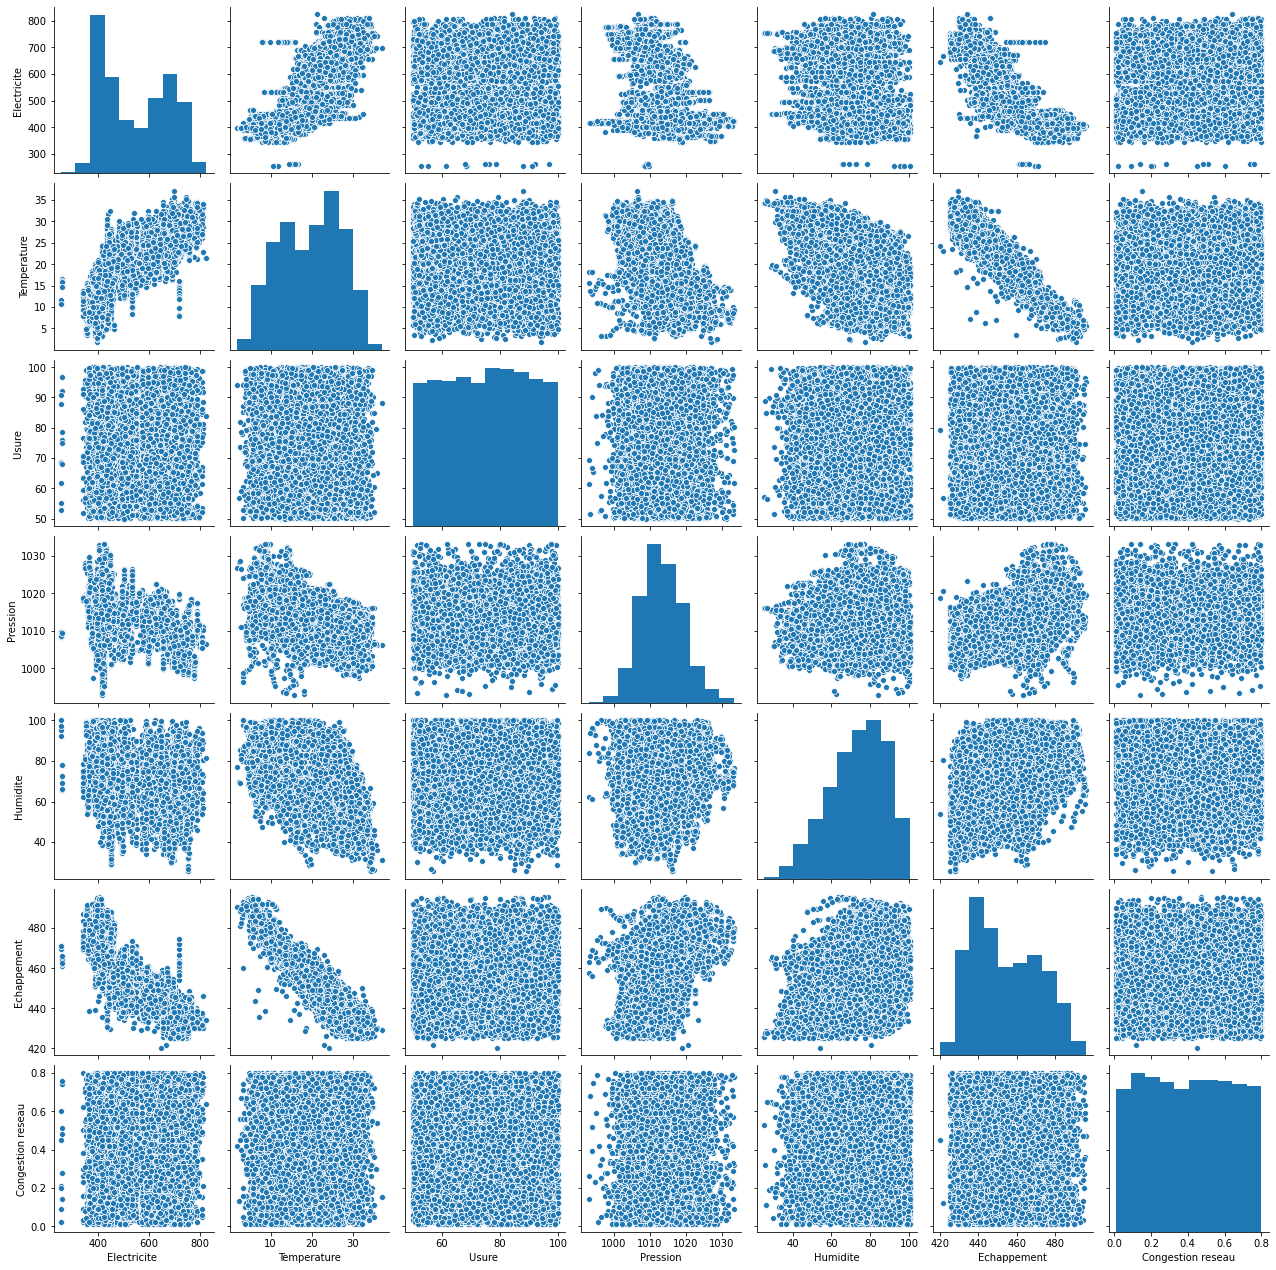

In [5]:
sns.pairplot(data)

- la visulasitation des corrélations éstimées entre les variables de notre jeu de données , renfocrcent les remarques tirées au dessus.

In [6]:
data.corr()

,Electricite,Temperature,Usure,Pression,Humidite,Echappement,Congestion reseau
Electricite,1.000000,0.844107,0.008850,-0.413502,-0.312187,-0.869780,0.018027
Temperature,0.844107,1.000000,0.004139,-0.507549,-0.542535,-0.948128,0.015563
Usure,0.008850,0.004139,1.000000,-0.001928,-0.009143,-0.004381,0.002575
Pression,-0.413502,-0.507549,-0.001928,1.000000,0.099574,0.518429,-0.014251
Humidite,-0.312187,-0.542535,-0.009143,0.099574,1.000000,0.389794,-0.000034
Echappement,-0.869780,-0.948128,-0.004381,0.518429,0.389794,1.000000,-0.009402
Congestion reseau,0.018027,0.015563,0.002575,-0.014251,-0.000034,-0.009402,1.000000


## Test des modèles linéaires

#### On commence par essayer des modèles linéaires:  

   + on définit comme score la racine de la moyenne des carrés résiduelles $RMSE(\hat{y}, y) = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$

In [235]:
def RMSE(x, rounded = None):
    if rounded is not None:
        return round(np.sqrt(np.mean(x**2)), rounded)
    return np.sqrt(np.mean(x**2))

    - baseline estimation :  estimateur qui prédit la moyenne des valeurs de l'energie produite

In [236]:
str_baseline = f"l'erreur du baseline estimator est de : {RMSE(data['Electricite '] - data['Electricite '].mean(), 4)}"
print(str_baseline)

l'erreur du baseline estimator est de : 128.343


      - modèle de régression multivariée 

- splitt des données entre jeu de données d'entrainement(70%) et  de test (30%)  

In [237]:
train_data, test_data = train_test_split(data, test_size=0.3, train_size=0.7)

X_train = train_data[[col for col in train_data if col!= 'Electricite ']]
Y_train = train_data[['Electricite ']]

X_test = test_data[[col for col in train_data if col!= 'Electricite ']]
Y_test = test_data[['Electricite ']]

- entrainement du modèle de regression: 

In [238]:
X_train_ = sm.add_constant(X_train)
model_reg = sm.OLS(Y_train, X_train_).fit()
model_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Electricite    R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     3713.
Date:                Tue, 19 Jan 2021   Prob (F-statistic):               0.00
Time:                        12:29:47   Log-Likelihood:                -37089.
No. Observations:                6697   AIC:                         7.419e+04
Df Residuals:                    6690   BIC:                         7.424e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               485.5033    174.950      2.775      0.006     142.545     828.462
Temperature           7.5271      0.397     18.945      0.000       6.748       8.306
Usure                 0.0687      0.053      1.303      0.193      -0.035       0.172
Pression              1.6544      0.152     10.867      0.000       1.356       1.953
Humidite              1.0807      0.071     15.321      0.000       0.942       1.219
Echappement          -4.0687      0.156    -26.032      0.000      -4.375      -3.762
Congestion reseau     6.2607      3.285      1.906      0.057      -0.180      12.701
==============================================================================
Omnibus:                       44.780   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.080
Skew:                          -0.135   Prob(JB):                     2.98e-12
Kurtosis:                       3.343   Cond. No.                     2.60e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- comme prévu les coefficients des variables usure et congestion réseau ne sont pas significatives: 
    - en effet vu les p-values pour ces deux features (0.0.57 et 0.193), on a pas assez de preuve pour rejetter les hypothèses nulles ($\beta_{usure}$ = 0 et $\beta_{congestion}$ = 0 ).
    -  on décide ainsi de conserver les hypothèses nulles pour  pour le test de student pour ces deux variables avec un risque de première espèce de 5 %

In [313]:
X_train_ = sm.add_constant(X_train)
X_train_ = X_train_[[col for col in X_train_.columns if col not in ['Usure ', 'Congestion reseau'] ]]
model_reg_ = sm.OLS(Y_train, X_train_).fit()
model_reg_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Electricite    R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     5565.
Date:                Tue, 19 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:46:37   Log-Likelihood:                -37091.
No. Observations:                6697   AIC:                         7.419e+04
Df Residuals:                    6692   BIC:                         7.423e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         492.8328    174.913      2.818      0.005     149.947     835.718
Temperature     7.5453      0.397     19.003      0.000       6.767       8.324
Pression        1.6515      0.152     10.846      0.000       1.353       1.950
Humidite        1.0836      0.071     15.368      0.000       0.945       1.222
Echappement    -4.0627      0.156    -26.011      0.000      -4.369      -3.756
==============================================================================
Omnibus:                       43.518   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.363
Skew:                          -0.133   Prob(JB):                     7.03e-12
Kurtosis:                       3.336   Cond. No.                     2.59e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.59e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- après supression des deux variables non informatives, on remarque que toutes les variables sont significatives.
    - toutes les p-values sont < 5 %
-  le $R^2$ ajusté est 76.9% on explique ainsi 76.9 % de la variance en ajoutant les 4 variables : Température, Echapppement, ...  

            - Etude des résiduelles :

* la droite de henri et la distibution plotté montrent que les erreurs sont approximativement gaussiens 

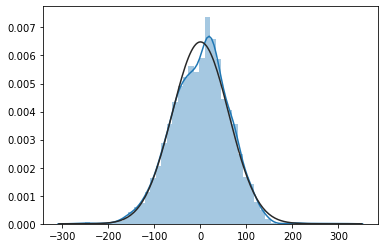

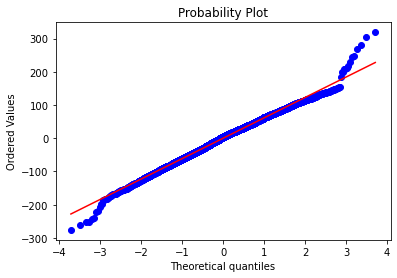

In [314]:
sns.distplot(model_reg_.resid, fit = norm)

fig = plt.figure()
res = stats.probplot(model_reg_.resid, plot = plt)
plt.show()

In [315]:
str_regression_training = f"l'erreur de l'estimation par regression linéaire sur les donneés d'entrainement est de : {RMSE(Y_train['Electricite '] - model_reg_.predict(X_train_), 4)}"
print(str_regression_training)

l'erreur de l'estimation par regression linéaire sur les donneés d'entrainement est de : 61.5322


In [316]:
X_test_ = sm.add_constant(X_test)
X_test_ = X_test_[[col for col in X_test_.columns if col not in ['Usure ', 'Congestion reseau'] ]]

str_regression_test = f"l'erreur de l'estimation par regression linéaire sur les donnés de test est de : {RMSE(Y_test['Electricite '] - model_reg_.predict(X_test_), 4)}"
print(str_regression_test)

l'erreur de l'estimation par regression linéaire sur les donnés de test est de : 61.1455


        - visualisation du scatter plot entre l'energie à prédire et celle prédite sur le training data set   

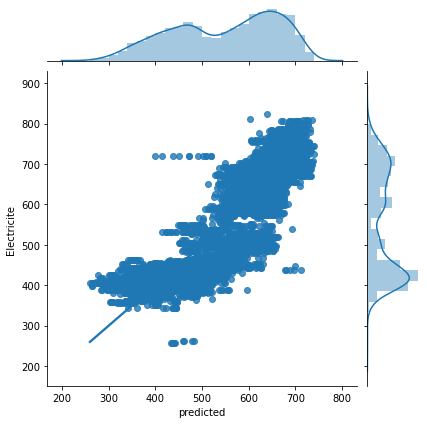

In [317]:
sns.jointplot(model_reg_.predict(X_train_).rename("predicted"), Y_train['Electricite '],
              kind = "reg" )

- on remarque que les variables explicatives dont on dispose sont seuls incapables d'expliquer une partie de la variance de valeurs de l'energie produite.
- ceci met en quesion l'hypothèse 0 qu'on a fait:  l'output est linéaire en fonction des input .
- avant de se lancer dans le test des modèles non linéaires, on peut se poser une hypothèse intermédiaire .
    - est-il possible que l'energie produite par la centrale est linéaire en fonction des varibales non globalement mais plutôt localement.
    - En d'autre termes, est-il envisagebale que l'effet de le température dépend da sa valeur; pourrant nous subdiviser l'intervalle des valeurs de la température en un nombre n  de sous intervalles et fitter une régression linéaire sur chaque sous-région en prennant en compre des conditions de continuité au bords des sous régions.
    - avec cette démarche on peut augmenter la fléxibilité de notre modèle sans être obligé d'ajouter des composantes ploynomiales qui peuvent avoir des effets de bors non souhaitables .

- on se propose donc dans un premier temps de travailler sur la variables température.
- on subdivise son intervalle de valeurs en 4 sous intervalles en précisant trois noeuds/ knots. 
- afin de garantir un nombre suffisant de points dans chaque sous région , les noeuds sont des quantiles régulièrement espacés.
- le degré des polynoms fittés dans chaque sous région est de 1, on peut faire plus pour avoir des fonctions plus lisses.
- vu le nombre de région qui est 4 (donc 2*4 paramètres des polynomes) et les conditions de continuité au bords des sous régiosn on aura 3 conditions de continuité soit donc  5 degrés de libertés( intercept inclus)

            - le code ci-dessous régresse la variable température sur l'energie produite et plotte l'effet de la température sur la prédiction

                            OLS Regression Results                            
Dep. Variable:           Electricite    R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     4851.
Date:                Tue, 19 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:49:36   Log-Likelihood:                -37439.
No. Observations:                6697   AIC:                         7.489e+04
Df Residuals:                    6692   BIC:                         7.492e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

Text(0, 0.5, 'effet de Temperature sur la prédiction')

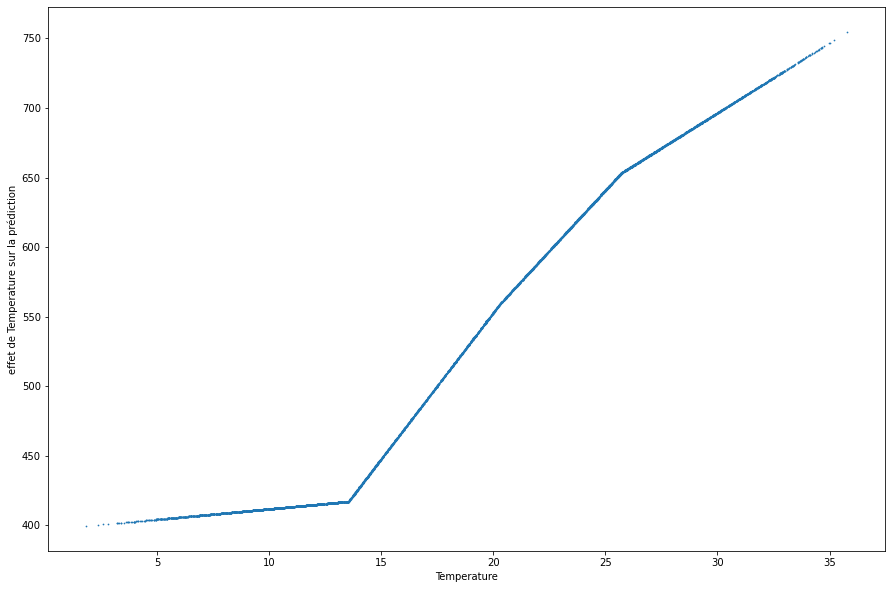

In [318]:
col = 'Temperature'
spline = dmatrix(f"bs(data['{col}'], degree = 1,  knots = {tuple(np.quantile(X_train[col],[0.25,0.5,0.75] ))})",\
                       {"data": X_train}, return_type = 'dataframe')

model_spline = sm.OLS(Y_train, spline).fit()
print(model_spline.summary())

fig, ax  = plt.subplots(figsize = (15,10))
ax.scatter(X_train[col], np.dot(spline, model_spline.params),s = 0.5)
ax.set_xlabel(col)
ax.set_ylabel(f'effet de {col} sur la prédiction')

- en visualisant les pentes de la température sur chaque sous région on voit que l'effet est différent selon la région.
- les coefficients estimés sont tous significatives (p_value < 5 %)
- la valeur du $R^2$ ajusté montre que le modèle explique presque le même variance que celle expliquée par le modèle de regression multivariée. 

on code un fonction *get_spline* qui facilite l'accés aux nouvelles features crées à partir d'une variable.

In [319]:
def get_spline(data, knots_number, col, train_data,  deg = 1): 
    return dmatrix(f"bs(data['{col}'], degree = {deg},  knots = {tuple(np.quantile(train_data[col],np.linspace(0,1,knots_number + 2)[1:-1] ))})",\
                       {"data": data}, return_type = 'dataframe')

- on s'interesse maintenemt au modèle qui prend en compte toute les features crées à partir de nos 4 variables initiales 

In [320]:
spline_pression = get_spline(X_train, 1, 'Pression', X_train)
spline_humidite = get_spline(X_train, 1, 'Humidite', X_train)
spline_temperature = get_spline(X_train, 5, 'Temperature', X_train)
spline_echappement = get_spline(X_train, 5, 'Echappement', X_train)

new_train_data = pd.concat([spline_echappement, spline_humidite, spline_temperature, spline_pression], axis = 1)
new_train_data.drop(columns = ['Intercept'], inplace = True)
new_train_data = sm.add_constant(new_train_data)

col_to_params = np.array(['intercept']*1 + ["Echappement"]*6 +  ['Humidite'] * 2 +  ['Temperature']*6 + ['Pression']*2)

In [321]:
model_spline = sm.OLS(Y_train, new_train_data).fit()
print(model_spline.summary())

                            OLS Regression Results                            
Dep. Variable:           Electricite    R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     1909.
Date:                Tue, 19 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:50:11   Log-Likelihood:                -36244.
No. Observations:                6697   AIC:                         7.252e+04
Df Residuals:                    6680   BIC:                         7.264e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

- tous les coeficients sont significatives (p-value <5%)
- le $R^2$ ajusté passe à 82.0% 

on commence par visualiser l'effet de de chacune des 4 variables sur la prédiction 

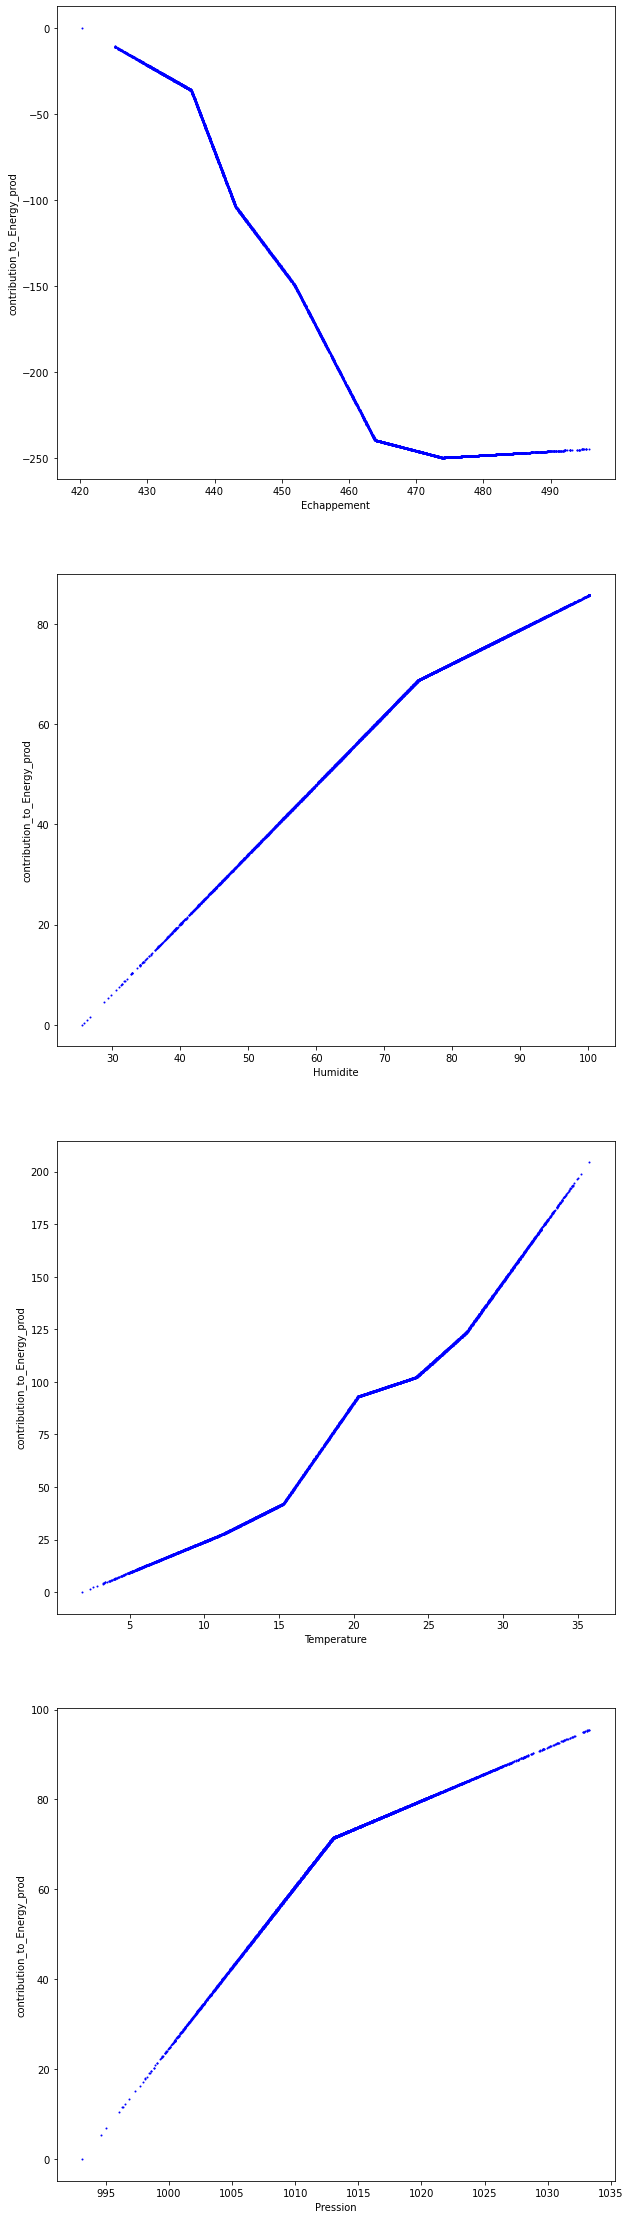

In [322]:
new_train_data_ = new_train_data * model_spline.params

cols = ['Echappement', 'Humidite', 'Temperature', 'Pression']
fig, ax = plt.subplots(nrows = len(cols), figsize =(10, 40)) 
for i, col in enumerate(cols): 
        ax[i].scatter(X_train[col], new_train_data_.iloc[:, col_to_params == col].sum(axis = 1), color = 'b', s = 1)
        ax[i].set_xlabel(col)
        ax[i].set_ylabel('contribution_to_Energy_prod')

étude de la normalité des erreurs : 

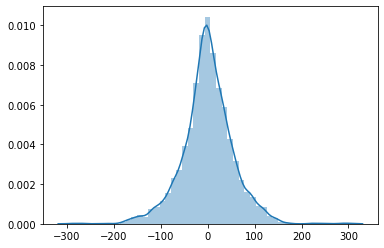

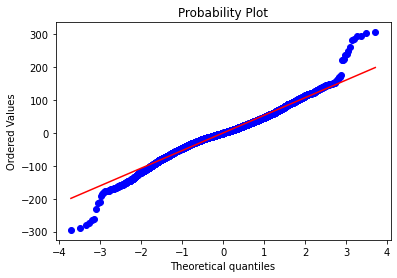

In [323]:
sns.distplot(model_spline.resid)

plt.figure()
resid = stats.probplot(model_spline.resid, plot =plt)

Erreur sur les données d'entrainement 

In [324]:
str_regression_spline_training = f"l'erreur de l'estimation par spline regression sur les donnés d'entrainement est de : {RMSE(model_spline.predict(new_train_data) - Y_train['Electricite '], 4)}"
print(str_regression_spline_training)

l'erreur de l'estimation par spline regression sur les donnés d'entrainement est de : 54.2226


In [325]:
spline_pression = get_spline(X_test, 1, 'Pression', X_train)
spline_humidite = get_spline(X_test, 1, 'Humidite', X_train)
spline_temperature = get_spline(X_test, 5, 'Temperature', X_train)
spline_echappement = get_spline(X_test, 5, 'Echappement', X_train)

new_test_data = pd.concat([spline_echappement, spline_humidite, spline_temperature, spline_pression], axis = 1)
new_test_data.drop(columns = ['Intercept'], inplace = True)
new_test_data = sm.add_constant(new_test_data)


str_regression_spline_test = f"l'erreur de l'estimation par spline regression  sur les données de test est de : {RMSE(model_spline.predict(new_test_data) - Y_test['Electricite '], 4)}"
print(str_regression_spline_test)

l'erreur de l'estimation par spline regression  sur les données de test est de : 53.6117


### Test des modèles non linéaires: 

#### Random Forest  model: 

In [326]:
X_train_ = X_train[[col for col in X_train.columns if col not in ['Usure ', 'Congestion reseau']]]
X_test_ = X_test[[col for col in X_test.columns if col not in ['Usure ', 'Congestion reseau']]]

In [327]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0, oob_score= True)
regressor.fit(X_train_, Y_train['Electricite '])

RandomForestRegressor(oob_score=True, random_state=0)

- erreur sur les données d'entrainement : 

In [328]:
RMSE(regressor.predict(X_train_) - Y_train['Electricite '], 4)

17.6131

- erreur sur les données de validation (out of bag):

In [329]:
RMSE(regressor.oob_prediction_ - Y_train['Electricite '], 4)

47.3968

    - L'erreur sur les données de validation est beaucoup plus grande que celle obtenue sur les données d'entraienemnt. 
    - Il est possible que le modèle à overfitter . 
    - on s'interesse donc à fine tuner les paramètres du modèle.
    - On n'optera pas pour le split des données d'entrainement, vu qu'on n'a pas assez de donées, on utilisera un K-fold validation croisée 

        - paramètres du modèle initial


In [330]:
regressor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

          - crétation d'une grille de recherche  

In [331]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 50, 100, 200], 
    'oob_score' :[ True]
}

        - choix optimal des paramètres. 

In [332]:
rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 1)
grid_search.fit(X_train_, Y_train['Electricite '])

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  8.6min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [10, 50, 100, 200],
                         'oob_score': [True]},
             verbose=1)

In [334]:
best_grid.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 110,
 'max_features': 2,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

        - paramètres du modèle optimisé

In [335]:
best_grid = grid_search.best_estimator_

- erreur sur les données d'entrainement : 

In [336]:
RMSE(best_grid.predict(X_train_) -  Y_train['Electricite '],4)

30.4453

- erreur sur les données de validation (out of bag):
    - on obtient une améloration par rapport au modèle random forest intial

In [337]:
RMSE(best_grid.oob_prediction_ - Y_train['Electricite '], 4)

46.9624

- erreur sur les données de Test:

In [338]:
RMSE(best_grid.predict(X_test_) - Y_test['Electricite '], 4)

45.84

- effet des features sur la prédiction: 

        + utilisation des features importannce fournies par l'estimateur.  

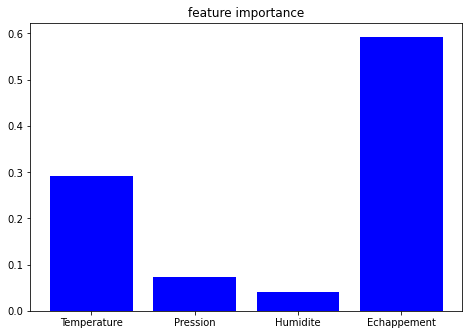

In [339]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
features  = X_train_.columns 
importances =  best_grid.feature_importances_ 
ax.bar(features,importances, color = 'b')
ax.set_title('feature importance')
plt.show()

        + utilisation des permutations importance pour s'assurer des features importances 

In [340]:
r = permutation_importance(best_grid, X_train_,Y_train ,n_repeats=30, random_state=0)

In [341]:
for i,feature in enumerate(X_train_.columns):
    print(f'feature importance for : {feature} is {round(r["importances_mean"][i], 3)} +/- {round(r["importances_std"][i], 3)}' )

feature importance for : Temperature is 0.356 +/- 0.006
feature importance for : Pression is 0.114 +/- 0.002
feature importance for : Humidite is 0.088 +/- 0.002
feature importance for : Echappement is 0.868 +/- 0.012


## comparaison des deux  modèles : 

- distribution des erreurs sur les donées de test :
    - spline regression vs random forest 
         - la distribution des erreurs des prédictions du modèle spline regression a une queue plus épaisse que celle avec random forest.
         - on peut visualise cela également en plottant la distribution des valeurs absolues des erreurs 

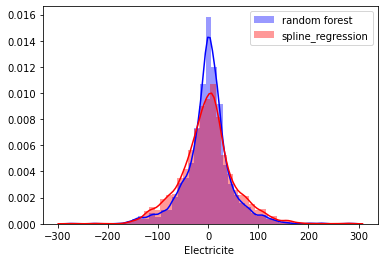

In [342]:
sns.distplot(best_grid.predict(X_test_) - Y_test['Electricite '], label = 'random forest', color = 'b')
sns.distplot(model_spline.predict(new_test_data) - Y_test['Electricite '], label = 'spline_regression', color = 'r')
plt.legend()

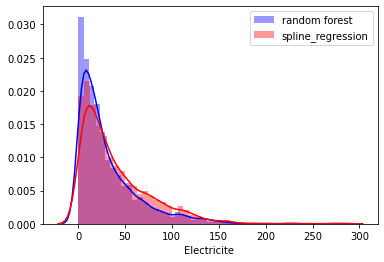

In [343]:
sns.distplot(np.abs(best_grid.predict(X_test_) - Y_test['Electricite ']), label = 'random forest', color = 'b')
sns.distplot(np.abs(model_spline.predict(new_test_data) - Y_test['Electricite ']), label = 'spline_regression', color = 'r')
plt.legend()

- comparaison du RMSE des erreurs de prédiction pour les deux modèles :  

In [344]:
str_spline = f'la RMSE sur les données de test pour le modèle spline regression est de :{ round(RMSE(model_spline.predict(new_train_data) - Y_train["Electricite "]), 4)}'
str_random = f'la RMSE sur les données de test pour le modèle random forest est de : {round(RMSE(best_grid.predict(X_test_) - Y_test["Electricite "]), 4)}'
print(str_spline)
print(str_random)

la RMSE sur les données de test pour le modèle spline regression est de :54.2226
la RMSE sur les données de test pour le modèle random forest est de : 45.84


* l'intérpretation des résultats dépend fortement de l'utilisation du modèle : 
    - si on cherche un modèle de prédiction sans avoir besoin d'intérpretation: 
        - le bon choix est le modèle basé sur le random forest qui donne une erreur minimale sur les données de validation et de test.
        - ce modèle permettra également de fournir des estimations des features importance, ce qui permet de construire une idée sur les variables qui ont impacté la prédiction du modèle sans pouvoir retracer le process de prédiction.
        - il est plausible que d'autres modèles non linéaires XGboost / résaux de neuronnes puissent donner des résultats bien meileures que le Random forest  
    - si on cherche un modèle interpretable qui nous permet de savoir l'effet marginal de chaque variables sur le prédiction; en d'autres termes pouvoir répondre à la question : "si x augmente de tant , y vas augmenter/ dimunier de combien ? "  
        - on optera pour le modèle linéaire.
        - on a néanmoins un coût d'erreur de prédiction à payer si on opte pour ce modèle.  